# Entregable 2

In [10]:
# Imports
import zipfile
import csv
from io import TextIOWrapper
from datetime import datetime
import numpy as np

from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Pre-procesamiento
El siguiente script accede al dataset provisto, el cual debe estar en su forma original en la carpeta ./dataset.
Para cada zip file (correspondiente a cada mes), se parsean las siguientes variables: fecha, tarjeta, corredor, linea, sentido. 

* `numtickets-day-month.csv` Este csv guarda los totalizadores de boletos por dia de la semana y mes del año segun siguiente estructura:
`|'month'|'acc-month'|'acc-sun'|'acc-monday'|'acc-tue'|'acc-wed'|'acc-thu'|'acc-fri'|'acc-sat'`
donde `acc` refiere al totalizador y donde las columnas representan los dias de la semana y las filas los meses del años.

* `datescards.csv` Este csv cuenta con una fila por cada tarjeta en la que se listan las fechas en las cuales la misma fue utilizada con la siguiente estructura: `|'card-id'|'date-1'|'date-2'|'date-3'|...` donde `card-id` es le número de la tarjeta continuada con a lista de `date-N` en las cuales la misma fue usada.

In [48]:
# [numtickets] two dimensional output list (keys: week-day, month - value: total ticket count)
numtickets = []
# [datescards] two dimensional output list (key: card number - value: list of dates used)
datescards = []

# Auxiliary array to keep track of card index in datescards
cards = []

# iterate by month 1-12
numtickets.append(['month','acc-month','acc-sun','acc-mon','acc-tue','acc-wed','acc-thu','acc-fri','acc-sat'])
for i in range(1, 12):

    # get list of csv file in zip for this month
    print('processing month', i)
    try:
        zip_file = zipfile.ZipFile('dataset/boletos_2019-{:02d}.zip'.format(i), 'r')
        csv_list = zip_file.infolist()
    except:
        continue

    # [numtickets] add row for this month in output list
    numtickets.append([i,0,0,0,0,0,0,0,0])

    # iterate for each day in month
    for csv_file in csv_list:

        print('processing', csv_file.filename)
        file = zip_file.open(csv_file.filename, 'r')
        csv_reader = csv.reader(TextIOWrapper(file, 'latin-1'), delimiter=';')

        # iterate for each ticket entry
        for r, row in enumerate(csv_reader):
            if r == 0:
                continue

            # get all variables from row
            fecha = datetime.strptime(row[0], '%d/%m/%Y %I:%M:%S %p')
            fecha_apertura = datetime.strptime(row[1], '%d/%m/%Y %I:%M:%S %p')
            tarjeta = int(row[2])
            corredor = row[3]
            linea = row[4]
            sentido = row[5]
            
            # [numtickets] accumulate numticket for this entry
            numtickets[-1][int(fecha.strftime('%w'))+2] += 1
            # [datescards] accumualte date in datescards for this card
            if tarjeta in cards:
                index = cards.index(tarjeta)
                datescards[index].append(fecha)
            else:
                datescards.append([tarjeta, fecha])
                cards.append(tarjeta)
        
        # accumulate per month
        numtickets[-1][1] = np.sum(numtickets[-1][2:])

# [numtickets] save output list as csv
with open('processed-data/numtickets-day-month.csv', 'w') as file:
    write = csv.writer(file)
    write.writerows(numtickets)
# [datescards] save output list as csv
with open('processed-data/datescards.csv', 'w') as file:
    write = csv.writer(file)
    write.writerows(datescards)

processing month 1
processing boletos_2019-01-01.csv
processing boletos_2019-01-02.csv
processing boletos_2019-01-03.csv
processing boletos_2019-01-04.csv


KeyboardInterrupt: 

## Gráficas Tarjetas por Fechas

En base a los datos de boletos acumulados obtenidos en `datescards.csv` realizamos un grafico con las N tarjetas más utilizadas de la base de datos.

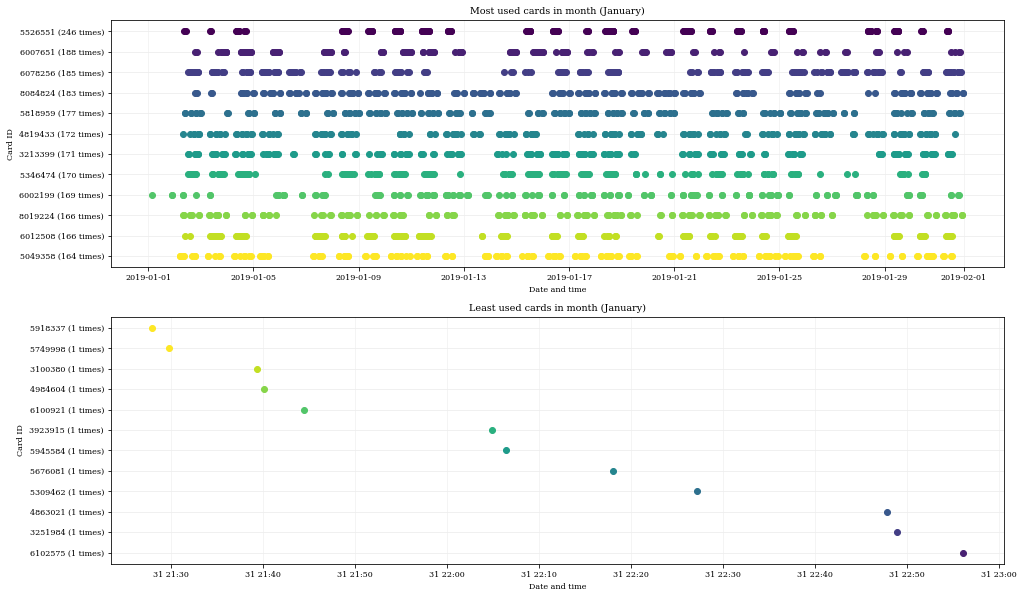

In [49]:
# read outlist from csv
with open("processed-data/datescards.csv", 'r') as file:
    csv_reader = csv.reader(file, delimiter=',')
    datescards = list(csv_reader)

# convert datetime format
for d in range(len(datescards)):
    datescards[d] = [datescards[d][0]] + [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in datescards[d][1:]]

# sort cards by len of list
datescards.sort(key=len, reverse=True)

# plot config: two plots side by side
font = {'family': 'serif',
        'weight': 'normal',
        'size': 8}
plt.rc('font', **font)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

# colormap
color_map = cm.get_cmap('viridis', 12)

# plot 1) N most used cards
axs[0].grid(axis='x', which='both', color='0.95')
axs[0].grid(axis='y', which='major', color='0.93')
axs[0].grid(axis='y', which='minor', color='0.96')

axs[0].set_title("Most used cards in month (January)")
axs[0].set_xlabel("Date and time")
axs[0].set_ylabel("Card ID")

# plot N most used cards
for n in reversed(range(12)):
    axs[0].scatter(datescards[n][1:], [item for item in [str(datescards[n][0]) + ' ({} times)'.format(len(datescards[n][1:]))] for i in range(len(datescards[n][1:]))],  color=color_map(n), zorder=10)

# plot 2) N least used cards
axs[1].grid(axis='x', which='both', color='0.95')
axs[1].grid(axis='y', which='major', color='0.93')
axs[1].grid(axis='y', which='minor', color='0.96')

axs[1].set_title("Least used cards in month (January)")
axs[1].set_xlabel("Date and time")
axs[1].set_ylabel("Card ID")

# plot n most used cards
for n in range(1,13):
    axs[1].scatter(datescards[-n][1:], [item for item in [str(datescards[-n][0]) + ' ({} times)'.format(len(datescards[-n][1:]))] for i in range(len(datescards[-n][1:]))],  color=color_map(n), zorder=10)

# save figure
plt.savefig("processed-data/datescards.png", format='png')
plt.savefig("processed-data/datescards.pdf", format='pdf')


    

## Gráficas Boletos Acumulados

En base a los datos de boletos acumulados obtenidos en `numtickets-day-month.csv` realizamos dos graficos, uno discriminado por dia de la semana y otro por mes del año.

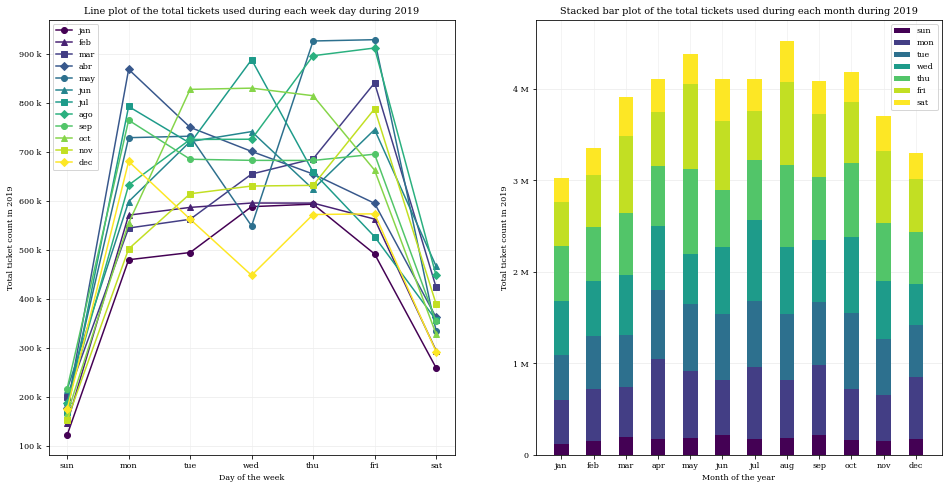

In [14]:
# read outlist from csv
with open("processed-data/numtickets-day-month.csv", 'r') as file:
    csv_reader = csv.reader(file, delimiter=',')
    numtickets = list(csv_reader)

# map to int
acc_month = [int(sub[1]) for sub in numtickets[1:]]
numtickets = [[int(num) for num in sub[2:]] for sub in numtickets[1:]]
    
# plot config: two plots side by side
font = {'family': 'serif',
        'weight': 'normal',
        'size': 8}
plt.rc('font', **font)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# colormap
color_map = cm.get_cmap('viridis', 12)

# plot 1) line plot
axs[0].grid(axis='x', which='both', color='0.95')
axs[0].grid(axis='y', which='major', color='0.93')
axs[0].grid(axis='y', which='minor', color='0.96')

# use k for thousends in y axis
axs[0].yaxis.set_major_formatter(ticker.EngFormatter())

axs[0].set_title("Line plot of the total tickets used during each week day during 2019")
axs[0].set_xlabel("Day of the week")
axs[0].set_ylabel("Total ticket count in 2019")
axs[0].xaxis.set_ticks([0,1,2,3,4,5,6,7])
axs[0].set_xticklabels(['','sun','mon','tue','wed','thu','fri','sat'])

# plot data from 12 months
axs[0].plot(range(1,8), numtickets[0], marker='o', color=color_map(0), label='jan')
axs[0].plot(range(1,8), numtickets[1], marker='^', color=color_map(1), label='feb')
axs[0].plot(range(1,8), numtickets[2], marker='s', color=color_map(2), label='mar')
axs[0].plot(range(1,8), numtickets[3], marker='D', color=color_map(3), label='abr')
axs[0].plot(range(1,8), numtickets[4], marker='o', color=color_map(4), label='may')
axs[0].plot(range(1,8), numtickets[5], marker='^', color=color_map(5), label='jun')
axs[0].plot(range(1,8), numtickets[6], marker='s', color=color_map(6), label='jul')
axs[0].plot(range(1,8), numtickets[7], marker='D', color=color_map(7), label='ago')
axs[0].plot(range(1,8), numtickets[8], marker='o', color=color_map(8), label='sep')
axs[0].plot(range(1,8), numtickets[9], marker='^', color=color_map(9), label='oct')
axs[0].plot(range(1,8), numtickets[10], marker='s', color=color_map(10), label='nov')
axs[0].plot(range(1,8), numtickets[11], marker='D', color=color_map(11), label='dec')

axs[0].legend()

# plot 2) stacked bar plot
axs[1].grid(axis='x', which='both', color='0.95')
axs[1].grid(axis='y', which='major', color='0.93')
axs[1].grid(axis='y', which='minor', color='0.96')

# use M for millions in y axis
axs[1].yaxis.set_major_formatter(ticker.EngFormatter())

axs[1].set_title("Stacked bar plot of the total tickets used during each month during 2019")
axs[1].set_xlabel("Month of the year")
axs[1].set_ylabel("Total ticket count in 2019")
axs[1].xaxis.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12])
axs[1].set_xticklabels(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])

# plot data from 12 months 
width = 0.45 
axs[1].bar(range(1,13), [item[0] for item in numtickets], width, color=color_map(0), zorder=10, label='sun')
bottom = [item[0] for item in numtickets]
axs[1].bar(range(1,13), [item[1] for item in numtickets], width, color=color_map(2), zorder=10, label='mon', bottom=bottom)
bottom = [a + b for a, b in zip(bottom, [item[1] for item in numtickets])]
axs[1].bar(range(1,13), [item[2] for item in numtickets], width, color=color_map(4), zorder=10, label='tue', bottom=bottom)
bottom = [a + b for a, b in zip(bottom, [item[2] for item in numtickets])]
axs[1].bar(range(1,13), [item[3] for item in numtickets], width, color=color_map(6), zorder=10, label='wed', bottom=bottom)
bottom = [a + b for a, b in zip(bottom, [item[3] for item in numtickets])]
axs[1].bar(range(1,13), [item[4] for item in numtickets], width, color=color_map(8), zorder=10, label='thu', bottom=bottom)
bottom = [a + b for a, b in zip(bottom, [item[4] for item in numtickets])]
axs[1].bar(range(1,13), [item[5] for item in numtickets], width, color=color_map(10), zorder=10, label='fri', bottom=bottom)
bottom = [a + b for a, b in zip(bottom, [item[5] for item in numtickets])]
axs[1].bar(range(1,13), [item[6] for item in numtickets], width, color=color_map(12), zorder=10, label='sat', bottom=bottom)
bottom = [a + b for a, b in zip(bottom, [item[6] for item in numtickets])]

axs[1].legend()

# save figure
plt.savefig("processed-data/numtickets-day-month.png", format='png')
plt.savefig("processed-data/numtickets-day-month.pdf", format='pdf')

## Conclusiones

Podemos observar a primera vista, que la frecuencia de corte de boletos es significativamente menor para fines de semana y para meses de verano en corelacion con las vacaciones de escuelas y muchas actividades, lo cual nos otorga cierto grado de confianza en los resultados obtenidos ya que se acomoda a lo esperado para futuros analisis.